# dividends vs no-dividends

Compare SPY with and without dividends.

In [1]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd

import pinkfish as pf

# Format price data.
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# Set size of inline plots.
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

In [3]:
symbol = 'SPY'
capital = 10000
start = datetime.datetime(1900, 1, 1)                   
end = datetime.datetime.now()

Timeseries

In [4]:
# Fetch timeseries, select, finalize.
ts = pf.fetch_timeseries(symbol)
ts = pf.select_tradeperiod(ts, start, end, use_adj=True)
ts, start = pf.finalize_timeseries(ts, start)

# Create tradelog and daily balance objects.
tlog = pf.TradeLog(symbol)
dbal = pf.DailyBal()

In [5]:
ts

,open,high,low,close,adj_close,volume
date,,,,,,
1993-01-29,24.86,24.86,24.73,24.84,24.84,1003200
1993-02-01,24.86,25.02,24.86,25.02,25.02,480500
1993-02-02,25.00,25.09,24.95,25.07,25.07,201300
1993-02-03,25.11,25.35,25.09,25.34,25.34,529400
1993-02-04,25.42,25.49,25.14,25.44,25.44,531500
...,...,...,...,...,...,...
2023-12-15,469.49,470.70,467.43,469.33,469.33,141319300
2023-12-18,470.98,472.98,469.89,471.97,471.97,70375300
2023-12-19,472.53,474.92,472.45,474.84,474.84,55761800


Algorithm

In [6]:
pf.TradeLog.cash = capital

# Loop through timeseries.
for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    end_flag = pf.is_last_row(ts, i)

    # Buy.
    if tlog.shares == 0:
        tlog.buy(date, row.close)
    # Sell.
    elif end_flag:
        tlog.sell(date, row.close)

    # Record daily balance.
    dbal.append(date, row.close)

Retrieve logs and get stats

In [7]:
tlog = tlog.get_log()
dbal = dbal.get_log(tlog)
stats = pf.stats(ts, tlog, dbal, capital)

Benchmark: Run, retrieve logs, generate stats

In [8]:
benchmark = pf.Benchmark(symbol, capital, start, end, use_adj=False)
benchmark.run()

Plot Equity Curves: Dividends (strategy) vs No-Dividends (benchmark)

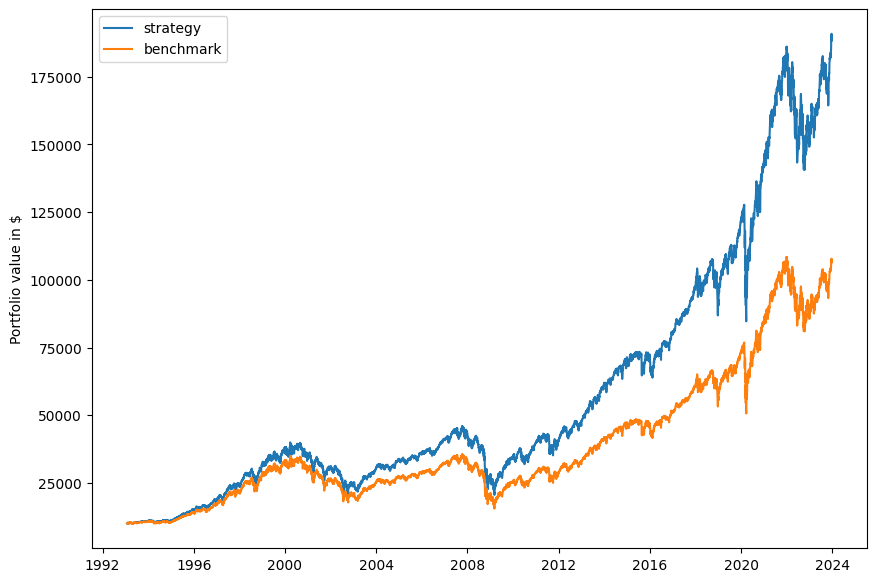

In [9]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal, fname='equity_curve.png')

Dividends (strategy) vs No-Dividends (benchmark)

In [10]:
pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$189,450.51","$106,996.53"
total_net_profit,"$179,450.51","$96,996.53"
gross_profit,"$179,450.51","$96,996.53"
gross_loss,$0.00,$0.00


,strategy,benchmark
annual_return_rate,9.99,7.97
max_closed_out_drawdown,-55.17,-56.43
annualized_return_over_max_drawdown,0.18,0.14
best_month,23.60,23.06
worst_month,-30.98,-31.38
sharpe_ratio,0.60,0.50
sortino_ratio,0.77,0.64
monthly_std,4.48,4.48
annual_std,17.01,16.68
avg_month,0.86,0.71


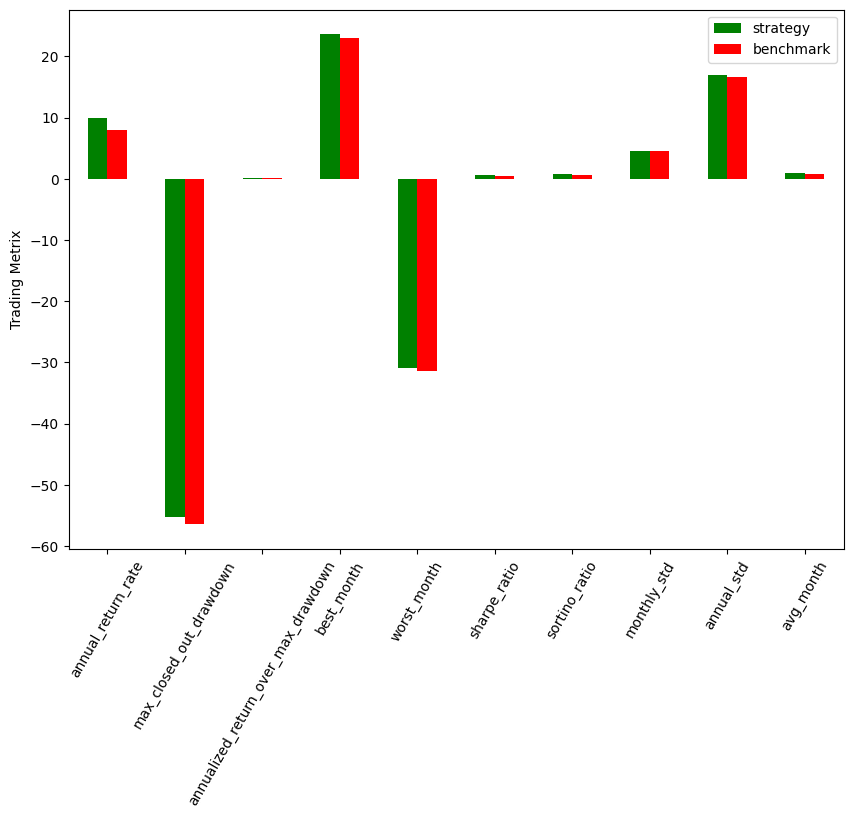

In [11]:
pf.plot_bar_graph(stats, benchmark.stats, extras=('avg_month',))